## Referencias

* https://www.ufrgs.br/wiki-r/index.php?title=Data_Frame (data frame)
* http://www.sthda.com/english/wiki/ggplot2-scatter-plots-quick-start-guide-r-software-and-data-visualization (ggplot2)
* https://statisticsglobe.com/heatmap-in-r (heatmap)


In [1]:
#install.packages("dplyr")
#install.packages("ggplot2") 
library("dplyr")
library("ggplot2")  


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adicionando o diretorio atual
setwd("../");

In [3]:
# Le o dataset com as colunas desejadas
dataset <- read.csv(file="./summer-products-with-rating-and-performance_2020-08.csv", header=TRUE, sep=",")
dataset <- as.data.frame(dataset)
base    <- select(dataset, price, units_sold, rating, rating_count, retail_price,  merchant_rating, merchant_rating_count)

# Nomes alternativos
colnames(base) <- c("Price", "Units Sold", "Rating", "Rating C", "Retail Price", "Merch R", "Merch C")

In [4]:
## Seçao de outliers
# Quartis
Q1 = 0.25
Q2 = 0.5
Q3 = 0.75
Q4 = 1.0

# Calcula Inter Quartile Range (IQR) da lista
iqrange <- function(arr)
{
    quantile(arr, Q3) - quantile(arr, Q1)
}

# Limpa outliers se baseando em uma coluna
limpaOutlier <- function(df, col)
{
    IQR = iqrange(unlist(df[[col]]))
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    subset(df, df[[col]] > lower & df[[col]] < upper)
}

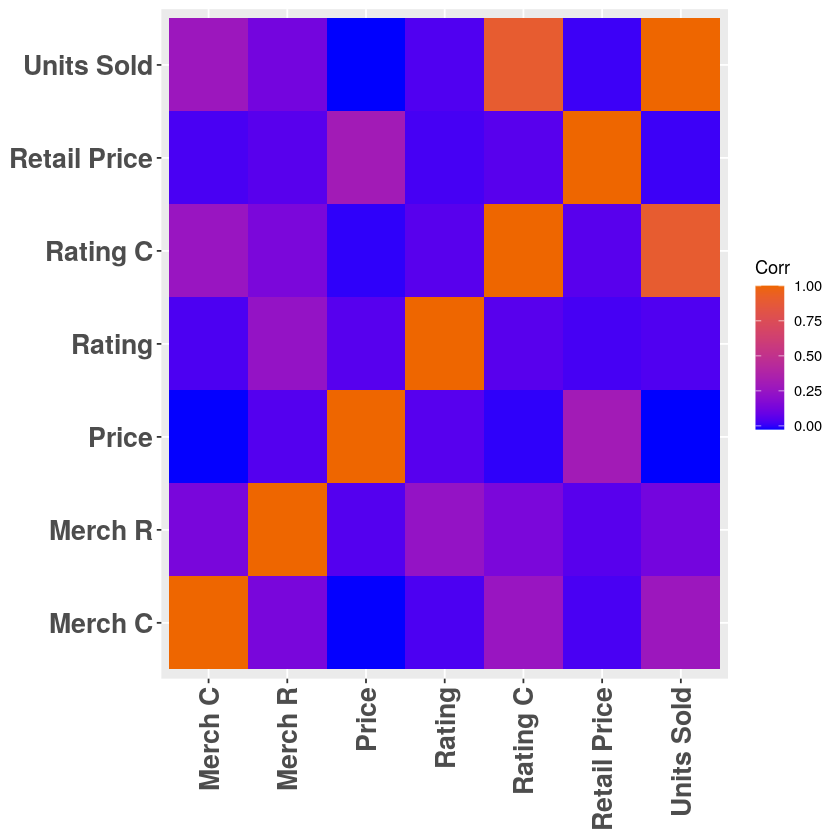

In [5]:
# Mapa de calor de correlacao
cor_map = data.frame(rows = rep(colnames(base), each = ncol(base)), cols = rep(colnames(base), each = 1, times=ncol(base)), Corr = c(cor(base)), stringsAsFactors=FALSE)

cor_heat = ggplot(cor_map, aes(rows, cols)) + geom_tile(aes(fill = Corr)) 
cor_heat = cor_heat + scale_fill_gradient(low = "#0000FF", high = "#EE6600") + theme(axis.title.y=element_blank(), axis.title.x=element_blank(), axis.text.x = 
element_text(angle = 90, vjust = 0.5, hjust=1, size=16, face="bold"), axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
cor_heat

# Eliminares os valores com correlacao quase perfeita e muita baixa
cor_map = subset(cor_map, (abs(Corr) < 0.99 & abs(Corr) > 0.2))

In [6]:
# Calcula novo cor_map aplicando remocao de outliers 2 a 2

cor_map$Corr_New <- NA
cor_rows = cor_map$"rows"
cor_cols = cor_map$"cols"

for(i in 1:(nrow(cor_map)))
{
    sub_base = limpaOutlier(base, cor_rows[[i]])
    sub_base = limpaOutlier(sub_base, cor_cols[[i]])
    sub_base = select(sub_base, cor_rows[i], cor_cols[[i]])
    cor_map[i, "Corr_New"] = cor(sub_base)[2]
}
cor_map_new <- subset(cor_map, abs(cor_map$Corr_New) > abs(cor_map$Corr))
cor_map
cor_map_new

,rows,cols,Corr,Corr_New
,<chr>,<chr>,<dbl>,<dbl>
5,Price,Retail Price,0.3047476,0.3992272
11,Units Sold,Rating C,0.8994637,0.6598791
14,Units Sold,Merch C,0.2728973,0.2758841
20,Rating,Merch R,0.2373051,NA
23,Rating C,Units Sold,0.8994637,0.6848825
28,Rating C,Merch C,0.2581676,0.2826965
29,Retail Price,Price,0.3047476,0.2520592
38,Merch R,Rating,0.2373051,NA
44,Merch C,Units Sold,0.2728973,0.2154947


,rows,cols,Corr,Corr_New
,<chr>,<chr>,<dbl>,<dbl>
5,Price,Retail Price,0.3047476,0.3992272
14,Units Sold,Merch C,0.2728973,0.2758841
28,Rating C,Merch C,0.2581676,0.2826965


In [7]:
cor_map

,rows,cols,Corr,Corr_New
,<chr>,<chr>,<dbl>,<dbl>
5,Price,Retail Price,0.3047476,0.3992272
11,Units Sold,Rating C,0.8994637,0.6598791
14,Units Sold,Merch C,0.2728973,0.2758841
20,Rating,Merch R,0.2373051,NA
23,Rating C,Units Sold,0.8994637,0.6848825
28,Rating C,Merch C,0.2581676,0.2826965
29,Retail Price,Price,0.3047476,0.2520592
38,Merch R,Rating,0.2373051,NA
44,Merch C,Units Sold,0.2728973,0.2154947


In [49]:
# Regressao Linear
lmGraph <- function(df, xcol, ycol, xcol_name="x", ycol_name="y")
{
    lmplot = ggplot(df, aes(x=xcol, y=ycol)) + geom_point()
    lmplot = lmplot + theme(axis.title.y=element_text(size=16, face="bold"), axis.title.x=element_text(size=16, face="bold"))
    lmplot = lmplot + labs(title="Regressão Linear Simples",x=xcol_name, y=ycol_name)
    lmplot = lmplot + theme(axis.text.x = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    lmplot = lmplot + theme(axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    lmplot = lmplot + geom_smooth(method=lm, se=FALSE, col="red")
    print(summary(lm(ycol~xcol)))
    print(lmplot)
}

# Regressao linear 2 a 2 em cada variavel do mapa de correlacao
for(i in 1:(nrow(cor_map)))
{
    fit = lm(base[[cor_rows[i]]]~base[[cor_cols[i]]])
    fits = summary(fit)
    print(paste(cor_rows[i], " - ", cor_cols[i], ";   R^2: ", fits$r.squared, ";   p-value: ", fits$coefficients[[2, 4]]))
}

[1] "Price  -  Retail Price ;   R^2:  0.0928711027523546 ;   p-value:  3.68287838857233e-35"
[1] "Units Sold  -  Rating C ;   R^2:  0.80903486165545 ;   p-value:  0"
[1] "Units Sold  -  Merch C ;   R^2:  0.0744729469619579 ;   p-value:  2.90448725478068e-28"
[1] "Rating  -  Merch R ;   R^2:  0.0563137324353463 ;   p-value:  1.41603365311663e-21"
[1] "Rating C  -  Units Sold ;   R^2:  0.80903486165545 ;   p-value:  0"
[1] "Rating C  -  Merch C ;   R^2:  0.0666504863311171 ;   p-value:  2.27981312009286e-25"
[1] "Retail Price  -  Price ;   R^2:  0.0928711027523548 ;   p-value:  3.68287838857281e-35"
[1] "Merch R  -  Rating ;   R^2:  0.0563137324353464 ;   p-value:  1.41603365311645e-21"
[1] "Merch C  -  Units Sold ;   R^2:  0.074472946961958 ;   p-value:  2.90448725478031e-28"
[1] "Merch C  -  Rating C ;   R^2:  0.0666504863311171 ;   p-value:  2.2798131200932e-25"



Call:
lm(formula = ycol ~ xcol)

Residuals:
    Min      1Q  Median      3Q     Max 
-76.990 -15.523 -10.465   3.947 229.477 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.7002     1.7081   2.166   0.0304 *  
xcol          2.3529     0.1855  12.682   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.92 on 1571 degrees of freedom
Multiple R-squared:  0.09287,	Adjusted R-squared:  0.09229 
F-statistic: 160.8 on 1 and 1571 DF,  p-value: < 2.2e-16



`geom_smooth()` using formula 'y ~ x'




Call:
lm(formula = ycol ~ xcol)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8062 -1.6339 -1.2718  0.5535 12.0965 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.16827    0.33109   9.569   <2e-16 ***
xcol         0.63794    0.05456  11.692   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.962 on 721 degrees of freedom
Multiple R-squared:  0.1594,	Adjusted R-squared:  0.1582 
F-statistic: 136.7 on 1 and 721 DF,  p-value: < 2.2e-16



`geom_smooth()` using formula 'y ~ x'



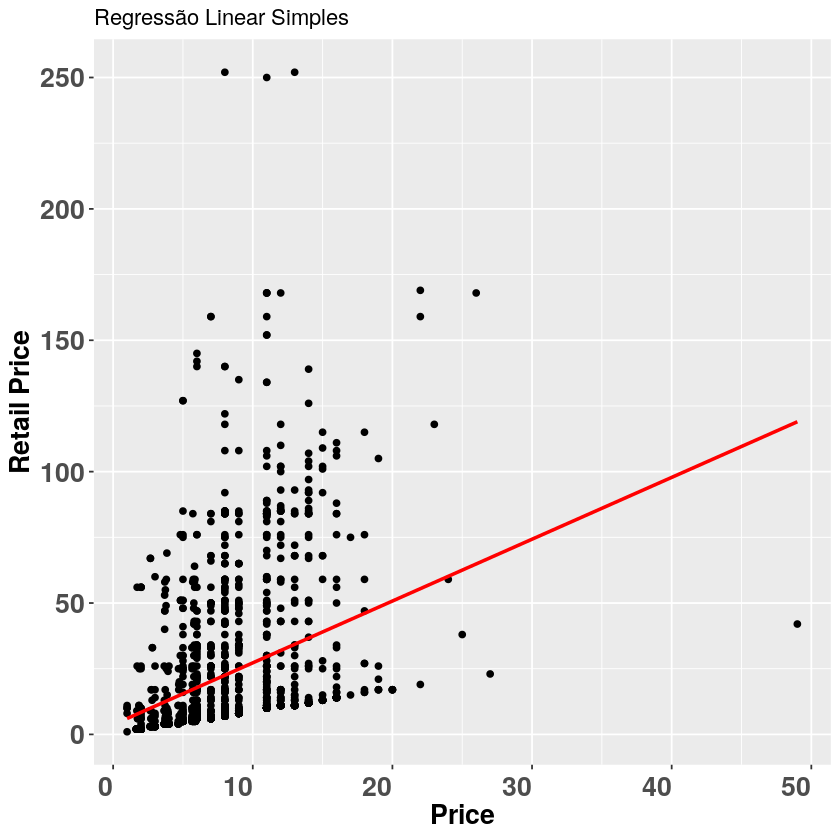

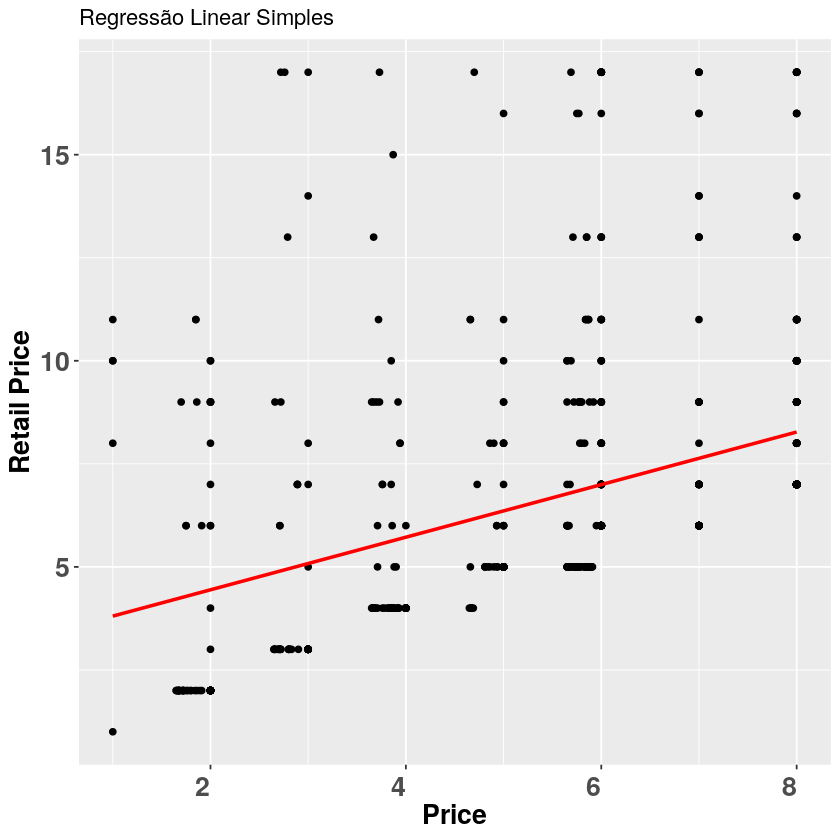

In [55]:
##Algumas analises simples com o novo cor_map
xc = "Price"; yc = "Retail Price";
# Normal
lmGraph(base, base[[xc]], base[[yc]], xcol_name=xc, ycol_name=yc)
# Sem outlier
sub_base = limpaOutlier(base, xc)
sub_base = limpaOutlier(sub_base, yc)
lmGraph(sub_base, sub_base[[xc]], sub_base[[yc]], xcol_name=xc, ycol_name=yc)

xc = "Rating C"; yc = "Merch C";
# Normal
lmGraph(base, base[[xc]], base[[yc]], xcol_name=xc, ycol_name=yc)
# Sem outlier
sub_base = limpaOutlier(base, xc)
sub_base = limpaOutlier(sub_base, yc)
lmGraph(sub_base, sub_base[[xc]], sub_base[[yc]], xcol_name=xc, ycol_name=yc)

xc = "Units Sold"; yc = "Merch C";
# Normal
lmGraph(base, base[[xc]], base[[yc]], xcol_name=xc, ycol_name=yc)
# Sem outlierb
sub_base = limpaOutlier(base, xc)
sub_base = limpaOutlier(sub_base, yc)
lmGraph(sub_base, sub_base[[xc]], sub_base[[yc]], xcol_name=xc, ycol_name=yc)

##Analise do Units sold
xc = "Rating C"; yc = "Units Sold";
# Normal
lmGraph(base, base[[xc]], base[[yc]], xcol_name=xc, ycol_name=yc)
# Sem outlier
sub_base = limpaOutlier(base, xc)
sub_base = limpaOutlier(sub_base, yc)
lmGraph(sub_base, sub_base[[xc]], sub_base[[yc]], xcol_name=xc, ycol_name=yc)

In [17]:
fit<-lm(base$"Units" ~ base$"Price" + base$"Rating" + base$"Retail Price" + base$"Merch C" + base$"Merch R")
summary(fit)


Call:
lm(formula = base$Units ~ base$Price + base$Rating + base$"Retail Price" + 
    base$"Merch C" + base$"Merch R")

Residuals:
   Min     1Q Median     3Q    Max 
-62426  -3747  -2711    836  96352 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.251e+04  4.549e+03  -2.750 0.006031 ** 
base$Price          -6.113e+01  6.058e+01  -1.009 0.313103    
base$Rating          2.121e+02  4.526e+02   0.468 0.639494    
base$"Retail Price"  2.459e+00  7.841e+00   0.314 0.753909    
base$"Merch C"       3.101e-02  2.915e-03  10.637  < 2e-16 ***
base$"Merch R"       3.886e+03  1.150e+03   3.379 0.000745 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8976 on 1567 degrees of freedom
Multiple R-squared:  0.08259,	Adjusted R-squared:  0.07966 
F-statistic: 28.21 on 5 and 1567 DF,  p-value: < 2.2e-16
